# **EUROVISION NETWORK ANALYSIS BY TEAM 6**

Team members:
*   BHOOMIKA BHAVIMATH - PES2UG19CS091
*   DEEPALI ATTAVAR - PES2UG19CS106

*   DEEPTHI B - PES2UG19CS107
*   D LASYA PRIYA - PES2UG19CS111

Problem statement: 

In [ ]:
#loading the dataset

import pandas as pd 
df = pd.read_excel('eurovision_song_contest_1975_2019.xlsx')
df.columns = ['year','final','edition','votetype','countryfrom','Country','points','duplicate'];
df.head(7)

,year,final,edition,votetype,countryfrom,Country,points,duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN
5,1975,f,1975f,J,Belgium,Israel,1,NaN
6,1975,f,1975f,J,Belgium,Italy,6,NaN


Data cleaning

In [ ]:
df2 = df.copy().query('points > 0')
df2.drop(columns=['duplicate','edition'], inplace=True, axis=1)     #dropping duplicate and edition column
df2.head(5)

,year,final,votetype,countryfrom,Country,points
2,1975,f,J,Belgium,France,2
4,1975,f,J,Belgium,Ireland,12
5,1975,f,J,Belgium,Israel,1
6,1975,f,J,Belgium,Italy,6
8,1975,f,J,Belgium,Malta,7


Visualisation

In [ ]:
#participation of countries with first year, last year, number of years and percentage

df2.groupby(['Country'])\
.apply(lambda x:pd.Series({'No. of Years':x['year'].nunique(),'First year':x['year'].min(),'Last Year':x['year'].max(),\
                           'Percentage':int(100*x['year'].nunique()/(x['year'].max()-x['year'].min()+1))}))\
                           .sort_values('No. of Years',ascending=False).style.bar(subset='No. of Years', color=['red'])

,No. of Years,First year,Last Year,Percentage
Country,,,,
Spain,44,1975,2019,97
Sweden,44,1975,2019,97
United Kingdom,44,1975,2019,97
France,44,1975,2019,97
Ireland,43,1975,2019,95
Germany,43,1975,2019,95
Belgium,42,1975,2019,93
The Netherlands,41,1975,2019,91
Norway,41,1975,2019,91


United Kingdom and Spain are the only countries to have participated in every eurovision song contest from 1975 to 2019

In [ ]:
#The Winner
df.query('final =="f"').groupby(['Country','year']).agg({'points':'sum'}).reset_index()\
  .groupby('year').apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
  .sort_values('year',ascending=False).head(15).T.style.set_caption("Winners")

,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30
Country,The Netherlands,Israel,Portugal,Ukraine,Sweden,Austria,Denmark,Sweden,Azerbaijan,Germany,Norway,Russia,Serbia,Finland,Greece
year,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005
points,492,529,758,534,365,290,281,372,221,246,387,272,268,292,230


In [ ]:
def TopCountry(df,tops):
  df2=df.groupby(['Country','year']).agg({'points':'sum'}).reset_index().groupby('year')
      
  top=df2.apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True).groupby('Country').agg({'year':'nunique'})\
    .rename(columns={'year':'years on top'}).reset_index()

  for t in tops:
      temp = df2.apply(lambda x:x.sort_values('points').tail(t)).reset_index(drop=True).groupby('Country').agg({'year':'nunique'})\
              .rename(columns={'year':f'years on top {t}'}).reset_index()
      top = pd.merge(top,temp, on='Country',how='outer')
          
  top = top.fillna(0);
  floatcols = top.columns[top.dtypes == 'float64']
  top[floatcols] = top[floatcols].astype(int)
  return top

In [ ]:
dfAtTop = TopCountry(df2.query('final =="f"'), tops=[3,5,7,10])
dfAtTop.sort_values(['years on top','years on top 3'], ascending=[False,False]).head(20)\
    .style.bar(subset=['years on top','years on top 3','years on top 5','years on top 7','years on top 10'])

,Country,years on top,years on top 3,years on top 5,years on top 7,years on top 10
9,Ireland,6,10,14,16,22
18,Sweden,4,11,19,23,29
10,Israel,4,7,10,14,18
23,United Kingdom,3,12,14,20,24
14,Norway,3,4,10,11,18
7,Germany,2,8,12,14,21
6,France,2,7,12,15,22
3,Denmark,2,5,9,12,17
22,Ukraine,2,5,6,8,9
20,The Netherlands,2,3,6,9,15


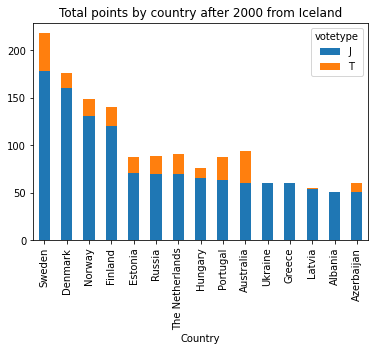

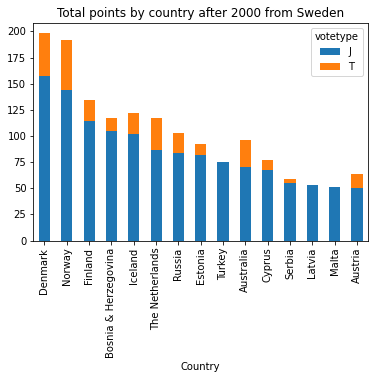

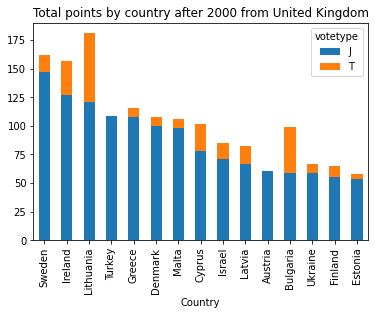

In [ ]:
%matplotlib inline
import pylab as plt

def plotRankByCountry(countryFrom, minYear, crop = 30):
    temp = df.query(f'year >= {minYear} and countryfrom=="{countryFrom}"')

    # top friends of Jury
    temp.pivot_table(index='Country',columns='votetype',values='points',aggfunc='sum').fillna(0).sort_values('J',ascending=False)\
    .head(crop).plot(kind='bar',stacked=True,title=f'Total points by country after {minYear} from {countryFrom}');

plotRankByCountry(countryFrom = 'Iceland', minYear = 2000, crop=15)
plotRankByCountry(countryFrom = 'Sweden', minYear = 2000, crop=15)
plotRankByCountry(countryFrom = 'United Kingdom', minYear = 2000, crop=15)

Sweden and Iceland are voted by its Neighbours while United Kingdom isnt. 

In [ ]:
#function to find the top N with most of point by countries

def selectTopPercent(x,column, percent=0.2, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum();
    cut = cut <= percent;
    
    #return at least the first and avoid warnings
    if retrieve_first and cut.sum() ==0:
        return x.iloc[0];
    
    return x[cut==True];

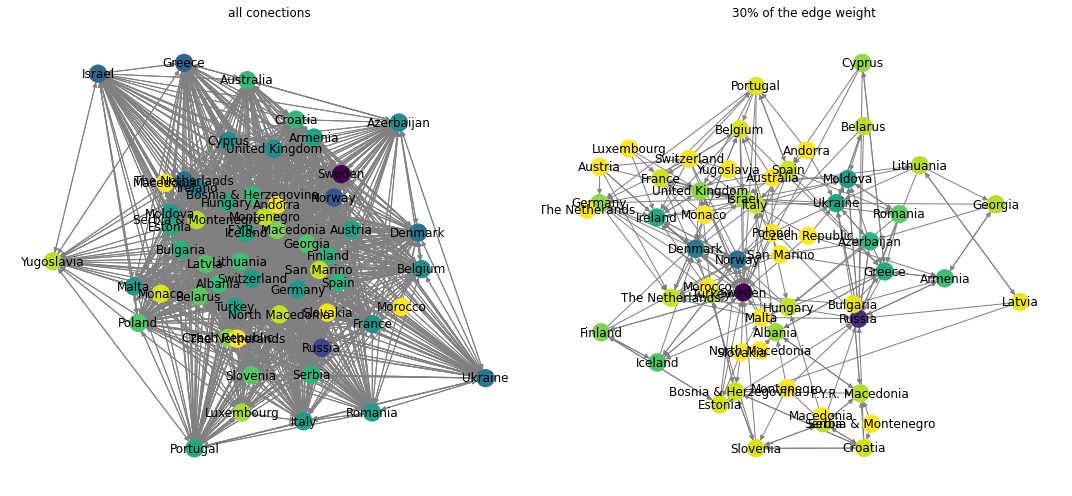

In [ ]:
#plot the graph network for the top N countries
import numpy as np
import networkx as nx
j=113

def plot(g, title, ax=None):
    if ax == None:
        ax = plt.gca();
        
    ax.set_title(title);
    
    np.random.seed(12)
    pos=nx.kamada_kawai_layout(g,weight='weight');
    nx.draw(g,
        pos = pos,
        ax=ax,
        cmap=plt.cm.viridis_r,
        edge_color='grey',
        node_color=list(nx.pagerank(g).values()),
        with_labels=True,
    )

plt.figure(figsize=(15,7));

#chart with all connections
plt.subplot(121);
temp = df2.groupby(['countryfrom','Country']).agg({'points':'sum'}).reset_index().rename(columns={'points':'weight'})

g = nx.from_pandas_edgelist(temp,'countryfrom','Country',['weight'], create_using=nx.OrderedDiGraph)
plot(g,title='all conections',ax=plt.gca())

# chart with only top connections
plt.subplot(122);
temp = df2.groupby(['countryfrom','Country']).agg({'points':'sum'}).reset_index().rename(columns={'points':'weight'})\
    .groupby(['countryfrom']).apply(selectTopPercent,'weight',0.3).reset_index(drop=True)

g = nx.from_pandas_edgelist(temp,'countryfrom','Country',['weight'], create_using=nx.OrderedDiGraph)
plot(g,title='30% of the edge weight',ax=plt.gca())

plt.tight_layout();

In [ ]:
#normalizing the data and finding associated count of countries related for particular out-degree.
def normalizer(x):
    x['points'] = x['points']/x['points'].sum()
    return x;

df3 = df.query('final=="f" and year >= 2000 ')\
    .groupby(['countryfrom','Country'])\
    .agg({'points':'sum'}).reset_index()\
    .groupby('countryfrom').apply(normalizer).reset_index(drop=True)\
    .groupby('countryfrom').apply(selectTopPercent,'points',0.30).reset_index(drop=True)\
    .rename(columns={'points':'weight'})

G = nx.from_pandas_edgelist(df3, 'countryfrom','Country', ['weight'], create_using=nx.OrderedDiGraph)

pd.DataFrame(dict(G.out_degree()).items(),columns=['country','out_degree']).groupby('out_degree').count()

,country
out_degree,
1,2
2,6
3,21
4,19
5,3


In [ ]:
import functools
nodeMeasures = {
    'pagerank':nx.pagerank(G,weight='weight', max_iter=1000),
    'eigevector':nx.algorithms.centrality.eigenvector_centrality(G,max_iter=1000),
    'degree':nx.algorithms.centrality.degree_centrality(G),
    'betweenness':nx.algorithms.centrality.betweenness_centrality(G),
    'closeness':nx.algorithms.centrality.closeness_centrality(G),
};

nodeMeasures = [pd.DataFrame(nodeMeasures[v].items(), columns=['country',v]) for v in nodeMeasures]

nodeMeasures = functools.reduce(lambda  left,right: pd.merge(left,right,on='country', how='outer'), nodeMeasures)

def pond(x):
    x['pond'] = (1+x[['pagerank','degree','closeness','betweenness']]).cumprod()[-1]-1;
    return x;

nodeMeasures = nodeMeasures.apply(pond,axis=1)

nodeMeasures.corr().style.background_gradient().format("{:.1%}")

,pagerank,eigevector,degree,betweenness,closeness,pond
pagerank,100.0%,96.8%,82.3%,57.8%,78.6%,89.9%
eigevector,96.8%,100.0%,69.8%,48.8%,76.8%,82.5%
degree,82.3%,69.8%,100.0%,80.6%,71.9%,93.5%
betweenness,57.8%,48.8%,80.6%,100.0%,66.6%,82.8%
closeness,78.6%,76.8%,71.9%,66.6%,100.0%,89.9%
pond,89.9%,82.5%,93.5%,82.8%,89.9%,100.0%


In [ ]:
nodeMeasures\
    .sort_values('pond',ascending=False).set_index('country').round(2)\
    .style.background_gradient(axis=0).format("{:.5}")

,pagerank,eigevector,degree,betweenness,closeness,pond
country,,,,,,
Russia,0.15,0.61,0.5,0.12,0.59,2.06
Sweden,0.07,0.14,0.52,0.18,0.4,1.69
Greece,0.08,0.42,0.26,0.14,0.5,1.33
Ukraine,0.08,0.32,0.26,0.02,0.47,1.04
Azerbaijan,0.08,0.34,0.22,0.02,0.46,0.95
Albania,0.03,0.15,0.18,0.13,0.39,0.91
Denmark,0.04,0.11,0.22,0.07,0.38,0.87
Turkey,0.02,0.08,0.2,0.1,0.38,0.86
Italy,0.02,0.05,0.24,0.11,0.33,0.86


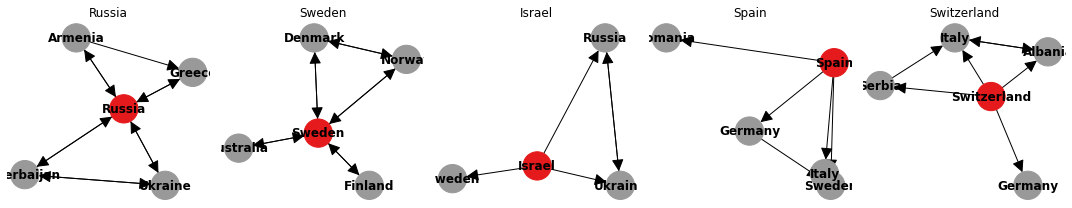

In [ ]:
#visualised egocentric network for the dataset.
def draw_ego(G, n):
    np.random.seed(12);
    G = nx.ego_graph(G,n, radius=1);
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G,pos = pos,
                   with_labels=True,arrowsize=25, font_color='black', font_weight='bold', node_size=800,
                   node_color=[2 if nn == n else 1 for nn in G],
                   cmap=plt.cm.Set1_r);

plt.figure(figsize=(15,3))
cs = ['Russia','Sweden', 'Israel','Spain','Switzerland',];
for i, c in enumerate(cs):
    plt.subplot(101+len(cs)*10+i)
    draw_ego(G,c)
    plt.gca().set_title(c)
    
plt.tight_layout()
plt.grid(False);

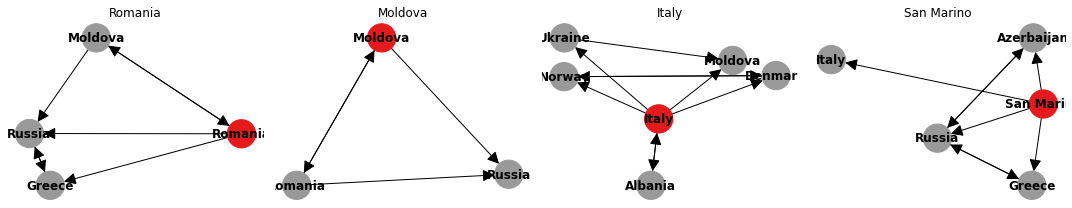

In [ ]:
plt.figure(figsize=(15,3))
cs = ['Romania','Moldova', 'Italy','San Marino',];
for i, c in enumerate(cs):
    plt.subplot(101+len(cs)*10+i)
    draw_ego(G,c)
    plt.gca().set_title(c)
    
plt.tight_layout()
plt.grid(False);

In [ ]:

influence = nx.pagerank(G,weight='weight')
influenceMax = max(influence.values())
print(influenceMax)

0.15198482834849242


In [ ]:
#cycle detection for directed graph

l = list(nx.simple_cycles(G))
l.sort()
print("cycles detected:", j)
for i in range(j):
  print("cycle",i,":")
  print(l[i])

cycles detected: 113
cycle 0 :
['Albania', 'Italy']
cycle 1 :
['Armenia', 'Georgia']
cycle 2 :
['Australia', 'Bulgaria', 'Armenia', 'Greece', 'Albania', 'Italy', 'Norway', 'Iceland', 'Sweden']
cycle 3 :
['Australia', 'Bulgaria', 'Armenia', 'Greece', 'Albania', 'Italy', 'Norway', 'Sweden']
cycle 4 :
['Australia', 'Bulgaria', 'Armenia', 'Greece', 'Albania', 'Turkey', 'Bosnia & Herzegovina', 'Serbia', 'Hungary', 'Sweden']
cycle 5 :
['Australia', 'Bulgaria', 'Armenia', 'Greece', 'Albania', 'Turkey', 'Bosnia & Herzegovina', 'Serbia', 'Hungary', 'The Netherlands', 'Sweden']
cycle 6 :
['Australia', 'Bulgaria', 'Armenia', 'Greece', 'Albania', 'Turkey', 'Bosnia & Herzegovina', 'Serbia', 'Italy', 'Norway', 'Iceland', 'Sweden']
cycle 7 :
['Australia', 'Bulgaria', 'Armenia', 'Greece', 'Albania', 'Turkey', 'Bosnia & Herzegovina', 'Serbia', 'Italy', 'Norway', 'Sweden']
cycle 8 :
['Australia', 'Bulgaria', 'Greece', 'Albania', 'Italy', 'Norway', 'Iceland', 'Sweden']
cycle 9 :
['Australia', 'Bulgaria',